# MonReader — Page Flip Classification
This notebook accompanies the MonReader project, which detects page flips from single image frames captured on-device.

## What this notebook contains
1. **Data**: loading and splitting into train/validation/test with leakage control.
2. **Model**: a compact CNN for binary classification.
3. **Training**: standard optimization with epoch-wise metric plots.
4. **Validation**: confusion matrix at 0.5, ROC/PR curves, **threshold selection by max F1**, and CM at that threshold.
5. **Test**: ROC/PR curves and final metrics at the **frozen validation threshold**.

### Primary metric
**F1 score** is the primary optimization target. The decision threshold is selected on validation and reused on test.

## Project Background

**MonReader** is a mobile-based document digitization solution designed for researchers and anyone in need of fast, high-quality, fully automatic bulk scanning. Users simply flip through pages, and MonReader handles the rest: it detects page flips from a low-resolution camera feed, captures a high-resolution image, detects and crops page boundaries, dewarps the perspective, enhances text contrast, and performs OCR with formatting preserved. The results are further refined by a machine learning-powered redactor.

Our broader mission is to make AI and computer vision practical and accessible, offering compact devices that recognize faces, clothing, motion, and objects—easily integrable into existing data flows.


### Data Description

We collected smartphone video clips labeled as either **"flipping"** or **"not flipping"**. These videos were segmented into short clips and saved as frame sequences on disk using the format:  
`<VideoID>_<FrameNumber>`.

### Imports
Load scientific Python stack and evaluation utilities used throughout this notebook.

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn.metrics import (
    roc_curve, auc,
    roc_curve, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, average_precision_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay
)

In [4]:
data_dir = '/kaggle/input/mon-reader/images/training/'
classes = os.listdir(data_dir)
for c in classes:
    print(f'there are {len(os.listdir(data_dir+c))} images in class {c}')

there are 1230 images in class notflip
there are 1162 images in class flip


The data set is balanced, there are comparable number of images in each class

Let's load the images now

### Data — Load & Split
Builds the training/validation datasets from the training directory and loads the held-out test set.

**Leakage control**: validation is derived from training; test remains untouched.

In [5]:
batch_size = 32
img_height = 256
img_width = 256

train_dir = '/kaggle/input/mon-reader/images/training'

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.1,
    subset="training",
    class_names=['notflip', 'flip'],
    seed=123,
    color_mode='rgb',
    crop_to_aspect_ratio=True,
    label_mode='binary',
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size)

test_dir = '/kaggle/input/mon-reader/images/testing'

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.1,
    subset="validation",
    class_names=['notflip', 'flip'],
    seed=123,
    color_mode='rgb',
    crop_to_aspect_ratio=True,
    label_mode='binary',
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    class_names=['notflip', 'flip'],
    color_mode='rgb',
    crop_to_aspect_ratio=True,
    label_mode='binary',
    shuffle=False,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2392 files belonging to 2 classes.
Using 2153 files for training.


I0000 00:00:1754677225.255137     575 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754677225.255905     575 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 2392 files belonging to 2 classes.
Using 239 files for validation.
Found 597 files belonging to 2 classes.


In [6]:
class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

Classes: ['notflip', 'flip']


In [28]:
# Performance optimizations to keep the input pipeline fast. No effect on metrics.

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Image Preview

Let's now look a few of the images to have a better idea of what we are working with

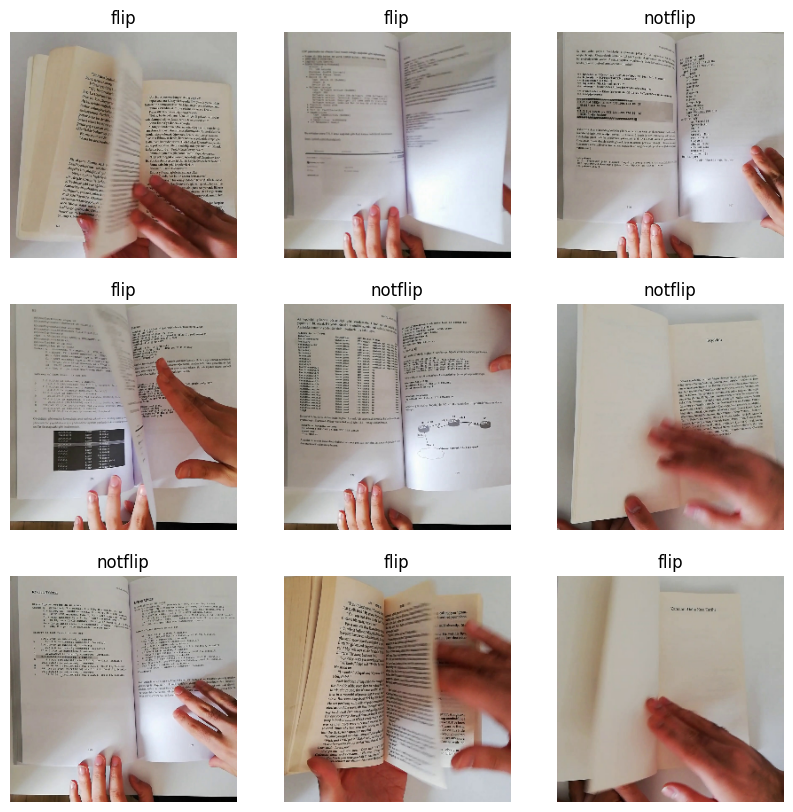

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        # print(labels.numpy())
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels.numpy().astype("uint8")[i][0]])
        plt.axis("off")

### Model — Compile
Optimization and metrics setup.
- **Loss:** `binary_crossentropy`.
- **Metrics:** Accuracy, Precision/Recall, ROC AUC and PR AUC. F1 score will be calculated manually from the final precision and recall.

In [12]:
img_size = (img_height, img_width)

cnn = Sequential([
    keras.Input(shape=(*img_size, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

cnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc-roc', curve='ROC'),
             tf.keras.metrics.AUC(name='aupr', curve='PR'),
            ]
)

cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       7,372,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,466,177 (28.48 MB)

 Trainable params: 7,466,177 (28.48 MB)

 Non-trainable params: 0 (0.00 B)

Before training the model let's create a function to plot the metrics

In [13]:
# Helper Plotting Function - Plot performance over epochs

def plot_training(history, title="Training & Validation Overview"):
    
    # Compute val-F1 from val-precision & val-recall
    
    p_val = np.array(history.history['val_precision'])
    r_val = np.array(history.history['val_recall'])
    f1_val = 2 * (p_val * r_val) / (p_val + r_val)

    p_tr = np.array(history.history['precision'])
    r_tr = np.array(history.history['recall'])
    f1_tr = 2 * (p_tr * r_tr) / (p_tr + r_tr)

    
    fig, axes = plt.subplots(2, 4, figsize=(21, 10))
    ax_loss = axes[0,0]
    ax_acc = axes[0,1]
    ax_p = axes[0,2]
    ax_r = axes[0,3]
    ax_f1 = axes[1,0]
    ax_auc = axes[1,1]
    ax_aupr = axes[1,2]
    
    # Plotting Loss
    ax_loss.plot(history.history['loss'],    marker='o', linestyle='-',  label='Training Loss')
    ax_loss.plot(history.history['val_loss'],marker='x', linestyle='--', label='Val Loss')
    ax_loss.set_title('Loss over Epochs')
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_loss.grid(alpha=0.3)
    ax_loss.legend()

    ax_acc.plot(history.history['accuracy'], marker='o', linestyle='-',  label='Accuracy')
    ax_acc.plot(history.history['val_accuracy'], marker='x', linestyle='-',  label='Validation Accuracy')
    ax_acc.set_title('Accuracy over Epochs')
    ax_acc.set_xlabel('Epoch')
    ax_acc.set_ylabel('Accuracy')
    ax_acc.grid(alpha=0.3)
    ax_acc.legend()

    ax_p.plot(history.history['precision'], marker='o', linestyle='-',  label='Precision')
    ax_p.plot(history.history['val_precision'], marker='x', linestyle='-',  label='Validation Precision')
    ax_p.set_title('Precision over Epochs')
    ax_p.set_xlabel('Epoch')
    ax_p.set_ylabel('Precision')
    ax_p.grid(alpha=0.3)
    ax_p.legend()

    ax_r.plot(history.history['recall'], marker='o', linestyle='-',  label='Recall')
    ax_r.plot(history.history['val_recall'], marker='x', linestyle='-',  label='Validation Recall')
    ax_r.set_title('Precision over Epochs')
    ax_r.set_xlabel('Epoch')
    ax_r.set_ylabel('Precision')
    ax_r.grid(alpha=0.3)
    ax_r.legend()

    ax_f1.plot(f1_tr, marker='o', linestyle='-',  label='F1 Score')
    ax_f1.plot(f1_val, marker='x', linestyle='-',  label='Validation F1 Score')
    ax_f1.set_title('F1 Score over Epochs')
    ax_f1.set_xlabel('Epoch')
    ax_f1.set_ylabel('F1 Score')
    ax_f1.grid(alpha=0.3)
    ax_f1.legend()

    ax_auc.plot(history.history['auc-roc'], marker='o', linestyle='-',  label='AUC ROC')
    ax_auc.plot(history.history['val_auc-roc'], marker='x', linestyle='-',  label='Validation AUC ROC')
    ax_auc.set_title('AUC ROC over Epochs')
    ax_auc.set_xlabel('Epoch')
    ax_auc.set_ylabel('AUC ROC')
    ax_auc.grid(alpha=0.3)
    ax_auc.legend()

    ax_aupr.plot(history.history['aupr'], marker='o', linestyle='-',  label='AUPR')
    ax_aupr.plot(history.history['val_aupr'], marker='x', linestyle='-',  label='Validation AUPR')
    ax_aupr.set_title('AUPR over Epochs')
    ax_aupr.set_xlabel('Epoch')
    ax_aupr.set_ylabel('AUPR')
    ax_aupr.grid(alpha=0.3)
    ax_aupr.legend()

    
    fig.suptitle(title, fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## Training

In [14]:
# Train and fit the model

history_cnn = cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15
)

Epoch 1/15


I0000 00:00:1754677375.270389     634 service.cc:148] XLA service 0x78c6140118b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754677375.270430     634 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754677375.270435     634 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754677375.888634     634 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/68 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.4444 - auc-roc: 0.4752 - aupr: 0.3565 - loss: 2.3584 - precision: 0.3333 - recall: 0.4861 

I0000 00:00:1754677382.512789     634 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


68/68 ━━━━━━━━━━━━━━━━━━━━ 30s 281ms/step - accuracy: 0.5457 - auc-roc: 0.5599 - aupr: 0.5309 - loss: 1.0258 - precision: 0.5265 - recall: 0.5981 - val_accuracy: 0.7615 - val_auc-roc: 0.8855 - val_aupr: 0.8873 - val_loss: 0.5347 - val_precision: 0.6835 - val_recall: 0.9391
Epoch 2/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.7454 - auc-roc: 0.8211 - aupr: 0.8107 - loss: 0.5288 - precision: 0.7626 - recall: 0.6826 - val_accuracy: 0.8787 - val_auc-roc: 0.9452 - val_aupr: 0.9493 - val_loss: 0.3001 - val_precision: 0.9216 - val_recall: 0.8174
Epoch 3/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.8390 - auc-roc: 0.9233 - aupr: 0.9244 - loss: 0.3530 - precision: 0.8683 - recall: 0.7834 - val_accuracy: 0.8703 - val_auc-roc: 0.9689 - val_aupr: 0.9630 - val_loss: 0.2862 - val_precision: 0.8088 - val_recall: 0.9565
Epoch 4/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.8925 - auc-roc: 0.9610 - aupr: 0.9598 - loss: 0.2537 - precision: 0.8932 - recall: 0.8821 - val

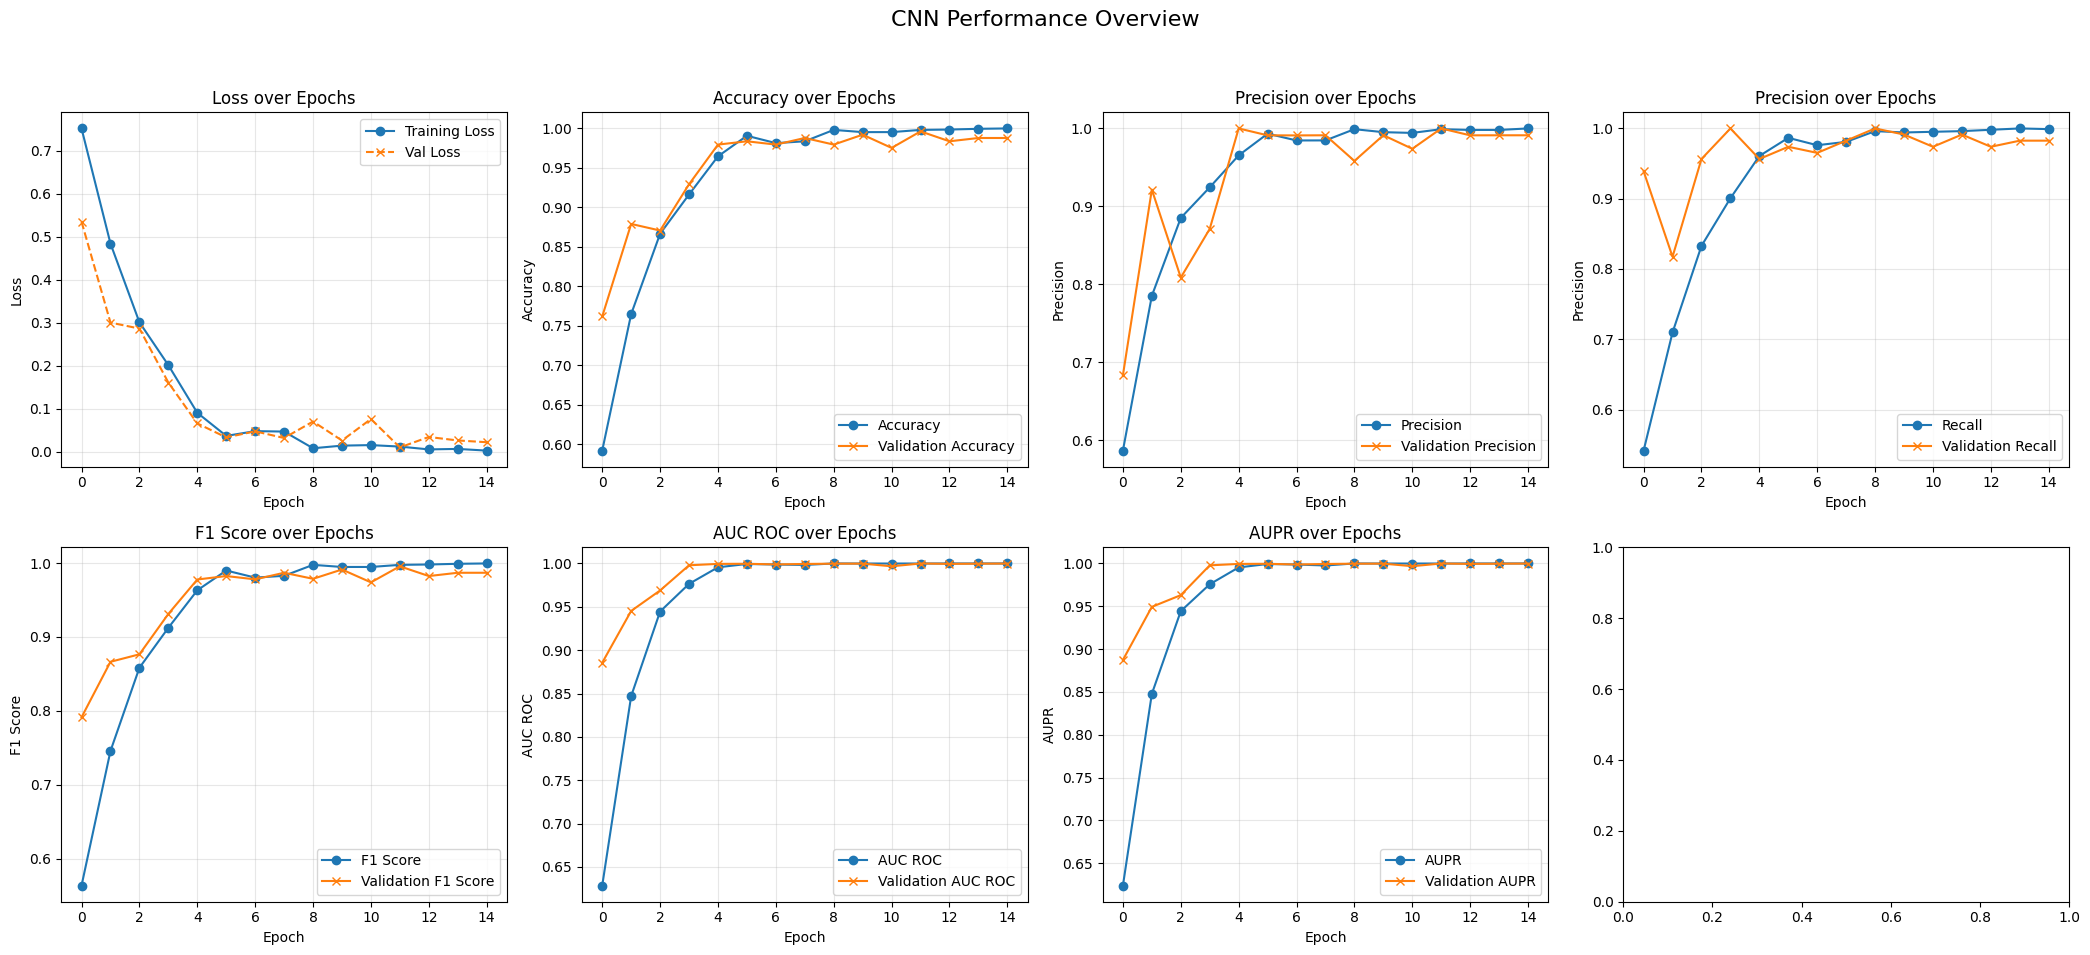

In [15]:
plot_training(history_cnn, "CNN Performance Overview")

## Validation Perfromance

### Confusion Matrix, ROC, PR
- **CM**: Baseline operating point that corresponds to the default threshold for Precision/Recall. We will later select operating threshold and compare with CM at that threshold.
- **PR & ROC Curve**: Both indicate a very strong performance

In [16]:
# Helper Functions

def true_labels(ds):
    ys = [y.numpy().ravel() for _, y in ds]
    return np.concatenate(ys).astype(int)

def pred_scores(model, ds):
    # Assumes sigmoid output for binary classification
    return model.predict(ds, verbose=0).ravel()

LABELS = CLASS_NAMES if 'CLASS_NAMES' in globals() else ['neg','pos']

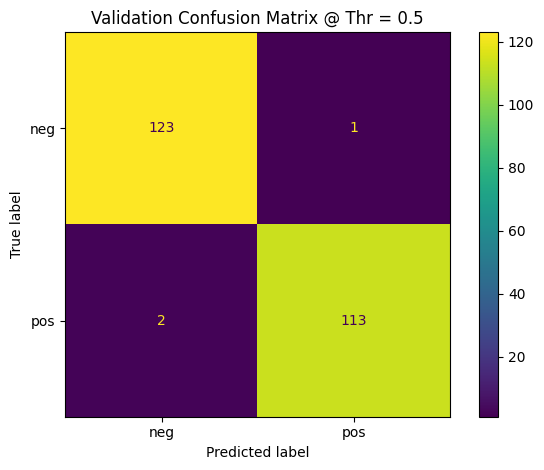

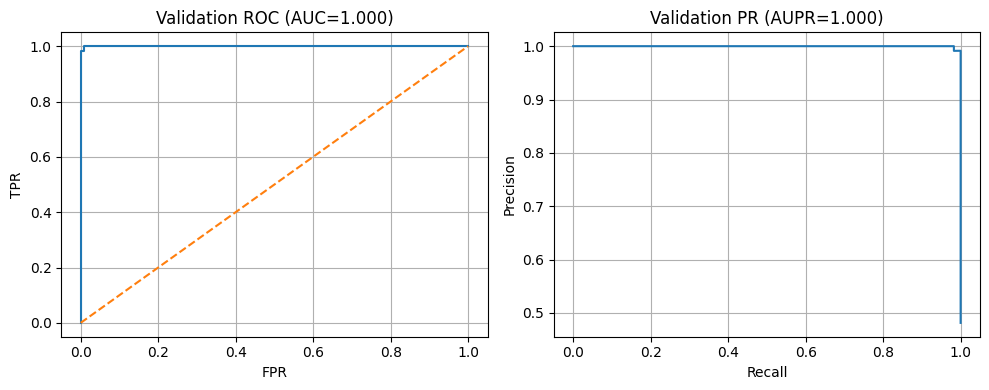

In [17]:
val_y      = true_labels(val_ds)
val_scores = pred_scores(cnn, val_ds)

# Confusion matrix at threshold 0.5
val_pred05 = (val_scores >= 0.5).astype(int)
cm_val_05  = confusion_matrix(val_y, val_pred05)
ConfusionMatrixDisplay(cm_val_05, display_labels=LABELS).plot(values_format='d')
plt.title("Validation Confusion Matrix @ Thr = 0.5")
plt.tight_layout(); plt.show()

# ROC & PR
val_fpr, val_tpr, _ = roc_curve(val_y, val_scores)
val_roc_auc = roc_auc_score(val_y, val_scores)
val_prec_curve, val_rec_curve, _ = precision_recall_curve(val_y, val_scores)
val_aupr = average_precision_score(val_y, val_scores)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]
ax.plot(val_fpr, val_tpr); ax.plot([0,1],[0,1], ls="--")
ax.set_title(f"Validation ROC (AUC={val_roc_auc:.3f})")
ax.set_xlabel("FPR"); ax.set_ylabel("TPR"); ax.grid(True)

ax = axes[1]
ax.plot(val_rec_curve, val_prec_curve)
ax.set_title(f"Validation PR (AUPR={val_aupr:.3f})")
ax.set_xlabel("Recall"); ax.set_ylabel("Precision"); ax.grid(True)

fig.tight_layout(); plt.show()

### Select Operating Threshold (Max F1)
The threshold is selected by maximizing **F1** on the validation set. This fixes a single operating point. A confusion matrix at the chosen threshold is shown for error analysis.

Chosen threshold (argmax F1): 0.019 | Val F1=0.9957


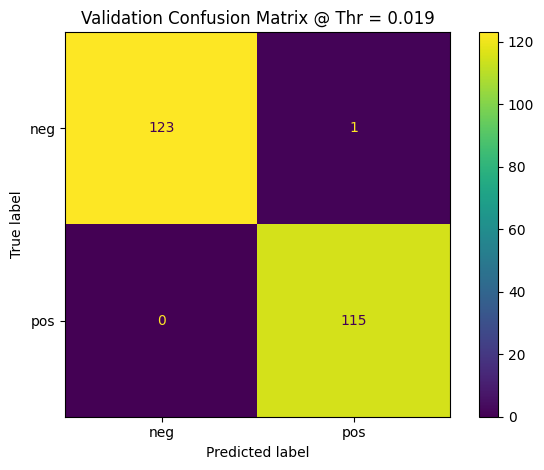

In [19]:
thr_grid = np.linspace(0.0, 1.0, 1001)

# Finding Optimal thrshold for maximum F1 Score

pred_grid = (val_scores[None, :] >= thr_grid[:, None]).astype(int)
tp = (pred_grid & (val_y[None, :] == 1)).sum(axis=1)
fp = (pred_grid & (val_y[None, :] == 0)).sum(axis=1)
fn = ((1 - pred_grid) & (val_y[None, :] == 1)).sum(axis=1)
val_f1s = (2 * tp) / np.clip(2 * tp + fp + fn, 1, None)

best_idx = int(np.argmax(val_f1s))
OPTIMAL_THRESHOLD = float(thr_grid[best_idx])
print(f"Chosen threshold (argmax F1): {OPTIMAL_THRESHOLD:.3f} | Val F1={val_f1s[best_idx]:.4f}")

# CM at chosen threshold
val_pred_opt = (val_scores >= OPTIMAL_THRESHOLD).astype(int)
cm_val_opt   = confusion_matrix(val_y, val_pred_opt)
ConfusionMatrixDisplay(cm_val_opt, display_labels=LABELS).plot(values_format='d')
plt.title(f"Validation Confusion Matrix @ Thr = {OPTIMAL_THRESHOLD:.3f}")
plt.tight_layout(); plt.show()

We are down to 1 missclassified record from previous 3 at this chosen threshold

## Test Set Performance

#### One-line summary
> On held-out test data, at the validation-chosen threshold (0.019): **F1=0.983**, **Precision=0.973**, **Recall=0.993**; **PR AUC=0.9987**, **ROC AUC=0.9984** (errors: **8 FP**, **2 FN**, N=597).

### Test-set results (threshold frozen from validation)

- **Threshold:** 0.019 (selected on validation by max **F1**, reused on test — no tuning on test)
- **Performance @ 0.5 threshold:** **ROC AUC = 0.9984**, **PR AUC = 0.9987**
- **At the chosen threshold:** **Precision = 0.9730**, **Recall = 0.9931**, **F1 = 0.9829** (Accuracy ≈ 0.983)

**Confusion matrix (counts)**


|            | Pred: neg | Pred: pos |
|------------|----------:|----------:|
| **True: neg** | **TN = 299** | **FP = 8**  |
| **True: pos** | **FN = 2**   | **TP = 288**|

---

#### Interpretation
- ROC/PR curves are near-ideal → ranking quality is excellent.
- The operating point favors **high recall** with slightly lower (still high) precision.
  - **FPR ≈ 2.6%** (8 / 307), **FNR ≈ 0.7%** (2 / 290).
- The **low threshold (0.019)** indicates negatives score very low; a small cutoff already captures almost all positives.

#### What to check next
- Inspect the **8 false positives** (likely motion/edge cases) and **2 false negatives** (subtle flips).

[TEST] ROC AUC=0.9984  AUPR=0.9987
[TEST @ Thr=0.019] Precision=0.9730  Recall=0.9931  F1=0.9829


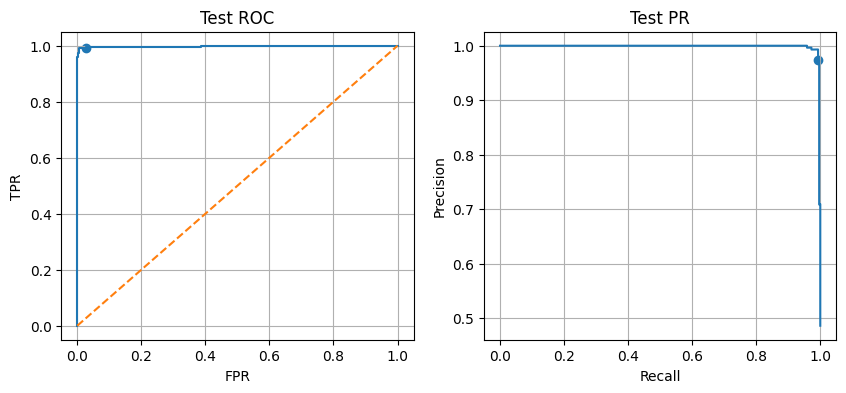

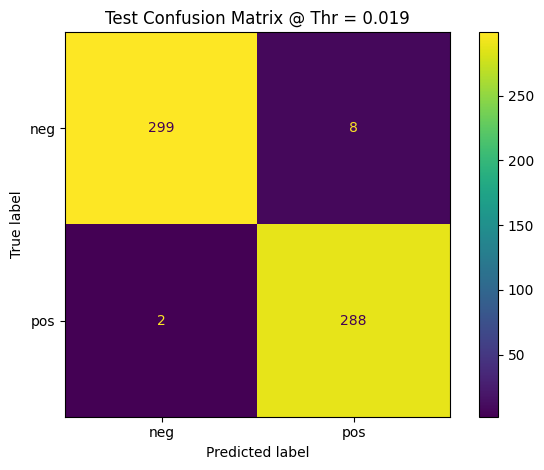

In [27]:
test_y = true_labels(test_ds)
test_scores = pred_scores(cnn, test_ds)

test_fpr, test_tpr, _ = roc_curve(test_y, test_scores)
test_prec_curve, test_rec_curve, _ = precision_recall_curve(test_y, test_scores)

test_pred = (test_scores >= OPTIMAL_THRESHOLD).astype(int)

# compute P/R and TPR/FPR at that threshold
P = precision_score(test_y, test_pred, zero_division=0)
R = recall_score(test_y, test_pred, zero_division=0)
cm = confusion_matrix(test_y, test_pred)
TP = cm[1,1]; FN = cm[1,0]; FP = cm[0,1]; TN = cm[0,0]
TPR = TP / (TP + FN) if (TP+FN) else 0.0
FPR = FP / (FP + TN) if (FP+TN) else 0.0


fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ax.plot(test_fpr, test_tpr); ax.plot([0,1],[0,1], ls="--")
ax.scatter([FPR], [TPR], marker='o')
ax.set_title("Test ROC"); ax.set_xlabel("FPR"); ax.set_ylabel("TPR"); ax.grid(True)

ax = axes[1]
ax.plot(test_rec_curve, test_prec_curve)
ax.scatter([R], [P], marker='o')
ax.set_title("Test PR"); ax.set_xlabel("Recall"); ax.set_ylabel("Precision"); ax.grid(True)

test_roc_auc = roc_auc_score(test_y, test_scores)
test_aupr    = average_precision_score(test_y, test_scores)

# Thresholded metrics @ chosen threshold
test_pred = (test_scores >= OPTIMAL_THRESHOLD).astype(int)
p = precision_score(test_y, test_pred, zero_division=0)
r = recall_score(test_y, test_pred, zero_division=0)
f1 = f1_score(test_y, test_pred, zero_division=0)

print(f"[TEST] ROC AUC={test_roc_auc:.4f}  AUPR={test_aupr:.4f}")
print(f"[TEST @ Thr={OPTIMAL_THRESHOLD:.3f}] Precision={p:.4f}  Recall={r:.4f}  F1={f1:.4f}")

cm_test = confusion_matrix(test_y, test_pred)
ConfusionMatrixDisplay(cm_test, display_labels=LABELS).plot(values_format='d')
plt.title(f"Test Confusion Matrix @ Thr = {OPTIMAL_THRESHOLD:.3f}")
plt.tight_layout(); plt.show()